# An AI agent learns to play tic-tac-toe (part 4): visualising the Q table using plotnine and ffmpeg
*Where we visualise the development of the Q table during the training process*

*This article is part of a series that lets a computer play tic-tac-toe using reinforcement learning. You can find [all the articles here](https://towardsdatascience.com/tagged/rl-series-paul). The goal is to provide a complete implementation that you can really pick apart and learn reinforcement learning from. It is probably best to read the articles in order. The article including all the code [can be found on Github]().*

# Visualising the learning process
It can be hard to really understand what a machine learning algorithm is doing. Especially when the performance is not improving the black box nature of machine learning can really make it hard to spot if the algorithm is actually learning anything. Being able to determine what the algorithm is learning can be really important in diagnosing what our black box approach is actually doing. 

In our case, the change in Q values represents the learning the RL agent is doing. Luckily for our simple tic-tac-toe game there is a very intuitive way to visualise the Q table. In the next figure we show the moves the players have already made using `X` and `O`:

![tree](example_qtable.png)

The `X` and `O` represent the state just before we have to make the decision, and the colored squares represent the Q values for the possible next moves. This confirms that the Q table stores the **policy**: what moves are good (high Q) given a certain board state. In this particular example figure we learned that the corners are good moves to make initially, which is obvious from the darker blue color. In addition, we learned to block moves by the tree search. Here the blocking move is blue, and the other moves are deeply red. 

# Building our visualisation
For our visualisation we need the following information from [a trained RL agent from part 3](https://towardsdatascience.com/an-ai-agent-learns-to-play-tic-tac-toe-part-3-training-a-q-learning-rl-agent-2871cef2faf0):

- A list with identifiers for all possible states in the qtable. This is stored as a sha1 hash of the boardstate array. This is in the order the states where added to the qtable over the learning proces. 
- A dictionary where the states are linked to the actual board state array
- A dictionary where the state is coupled to the Q values for the next possible actions, i.e. the Q table.

In [22]:
import dill

with open('rl_data.pkl', 'rb') as f:
    rl_data = dill.load(f)
states = rl_data[0]
board_states = rl_data[1]
qtable = rl_data[2]

print(states[12])
print(qtable[states[12]])
print(board_states[states[12]])

351d61138857f04cc521e13b7173f266420ea412
{'d': -3.7017636879676767, 'f': -3.5089737163159778, 'g': -3.5089737163159778, 'h': 3.9726827543029692, 'i': -3.63814513936129}
[[ 1. -1.  1.]
 [ 0. -1.  0.]
 [ 0.  0.  0.]]


Next we need to combine the board state data with the Q values:

In [20]:
import numpy as np
import pandas as pd

def try_na(qt, action):
    # See if an action exists for a given state, return NA if not
    # This is needed because in the 'q_values' list comprehension I simply
    # check all possible board moves.
    try:
        return qt[action]
    except KeyError:
        return np.nan

text_lut = {0: np.nan, 1: 'X', -1: 'O'}    # Translate 1 and -1 to 'X' and 'O'. Remember we are the 'X' player
plot_data = pd.DataFrame({'x': np.tile([1, 2, 3], 3), 'y': np.repeat([1, 2, 3], 3), 
                          'board_state': [text_lut[val] for val in board_states[states[12]].flatten()], 
                          'q_values': [try_na(qtable[states[12]], action) for action in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']], 
                          'sha1_state': states[12]})
print(plot_data)

   x  y board_state  q_values                                sha1_state
0  1  1           X       NaN  351d61138857f04cc521e13b7173f266420ea412
1  2  1           O       NaN  351d61138857f04cc521e13b7173f266420ea412
2  3  1           X       NaN  351d61138857f04cc521e13b7173f266420ea412
3  1  2         NaN -3.701764  351d61138857f04cc521e13b7173f266420ea412
4  2  2           O       NaN  351d61138857f04cc521e13b7173f266420ea412
5  3  2         NaN -3.508974  351d61138857f04cc521e13b7173f266420ea412
6  1  3         NaN -3.508974  351d61138857f04cc521e13b7173f266420ea412
7  2  3         NaN  3.972683  351d61138857f04cc521e13b7173f266420ea412
8  3  3         NaN -3.638145  351d61138857f04cc521e13b7173f266420ea412


For each x,y coordinate on the board we know the board_state and Q values. Note that these that obviously there can only ever by either a board state or Q value. Next we can plot this using a `geom_tile` from [`plotnine`](https://plotnine.readthedocs.io/en/stable/index.html):

/home/paul/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.


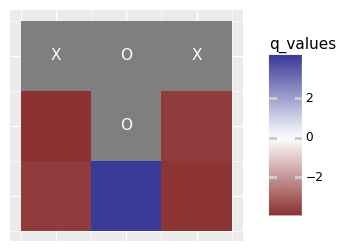

<ggplot: (8766103341011)>

In [19]:
from plotnine import *

(
    ggplot(plot_data, aes(x = 'x', y = 'y')) + 
        geom_tile(aes(fill = 'q_values')) + 
        geom_text(aes(label = 'board_state'), color = 'white') + 
        scale_fill_gradient2() +                                  # Colorscale from blue to red
        scale_y_reverse() +                                       # Reverse the y scale, or the game will be mirrored
        theme(figure_size=(3,3), axis_text=element_blank(), axis_ticks=element_blank(), 
              strip_text_x = element_blank(), axis_title=element_blank())  # Strip down to bare minimum
)

where the moves we already made (board_state) are the grey 'X' and 'O' and the Q values for next moves are the colored squares. If you are not familiar with plotnine or ggplot2, please [read this tutorial](https://datascienceworkshops.com/blog/plotnine-grammar-of-graphics-for-python/). 

# Visualise the entire qtable
With our visualisation for one board state out of the way, we need to scale this up to our entire Q table. So we:

- wrap the data generation part in a function, and call it for all possible states. We concatenate the result into one big `DataFrame`.
- add a call to `facet_wrap` in the `plotnine` code to create the visualised board state per unique state. 
- ensure the order of the visualisations per board state is in chronological order, i.e. as they where added to the Q table. I do this using `pd.Categorical`, where the order of the categorical variable is determined by the list passed to the `categories` argument. 

This yields the following result:

/home/paul/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 1617 rows containing missing values.


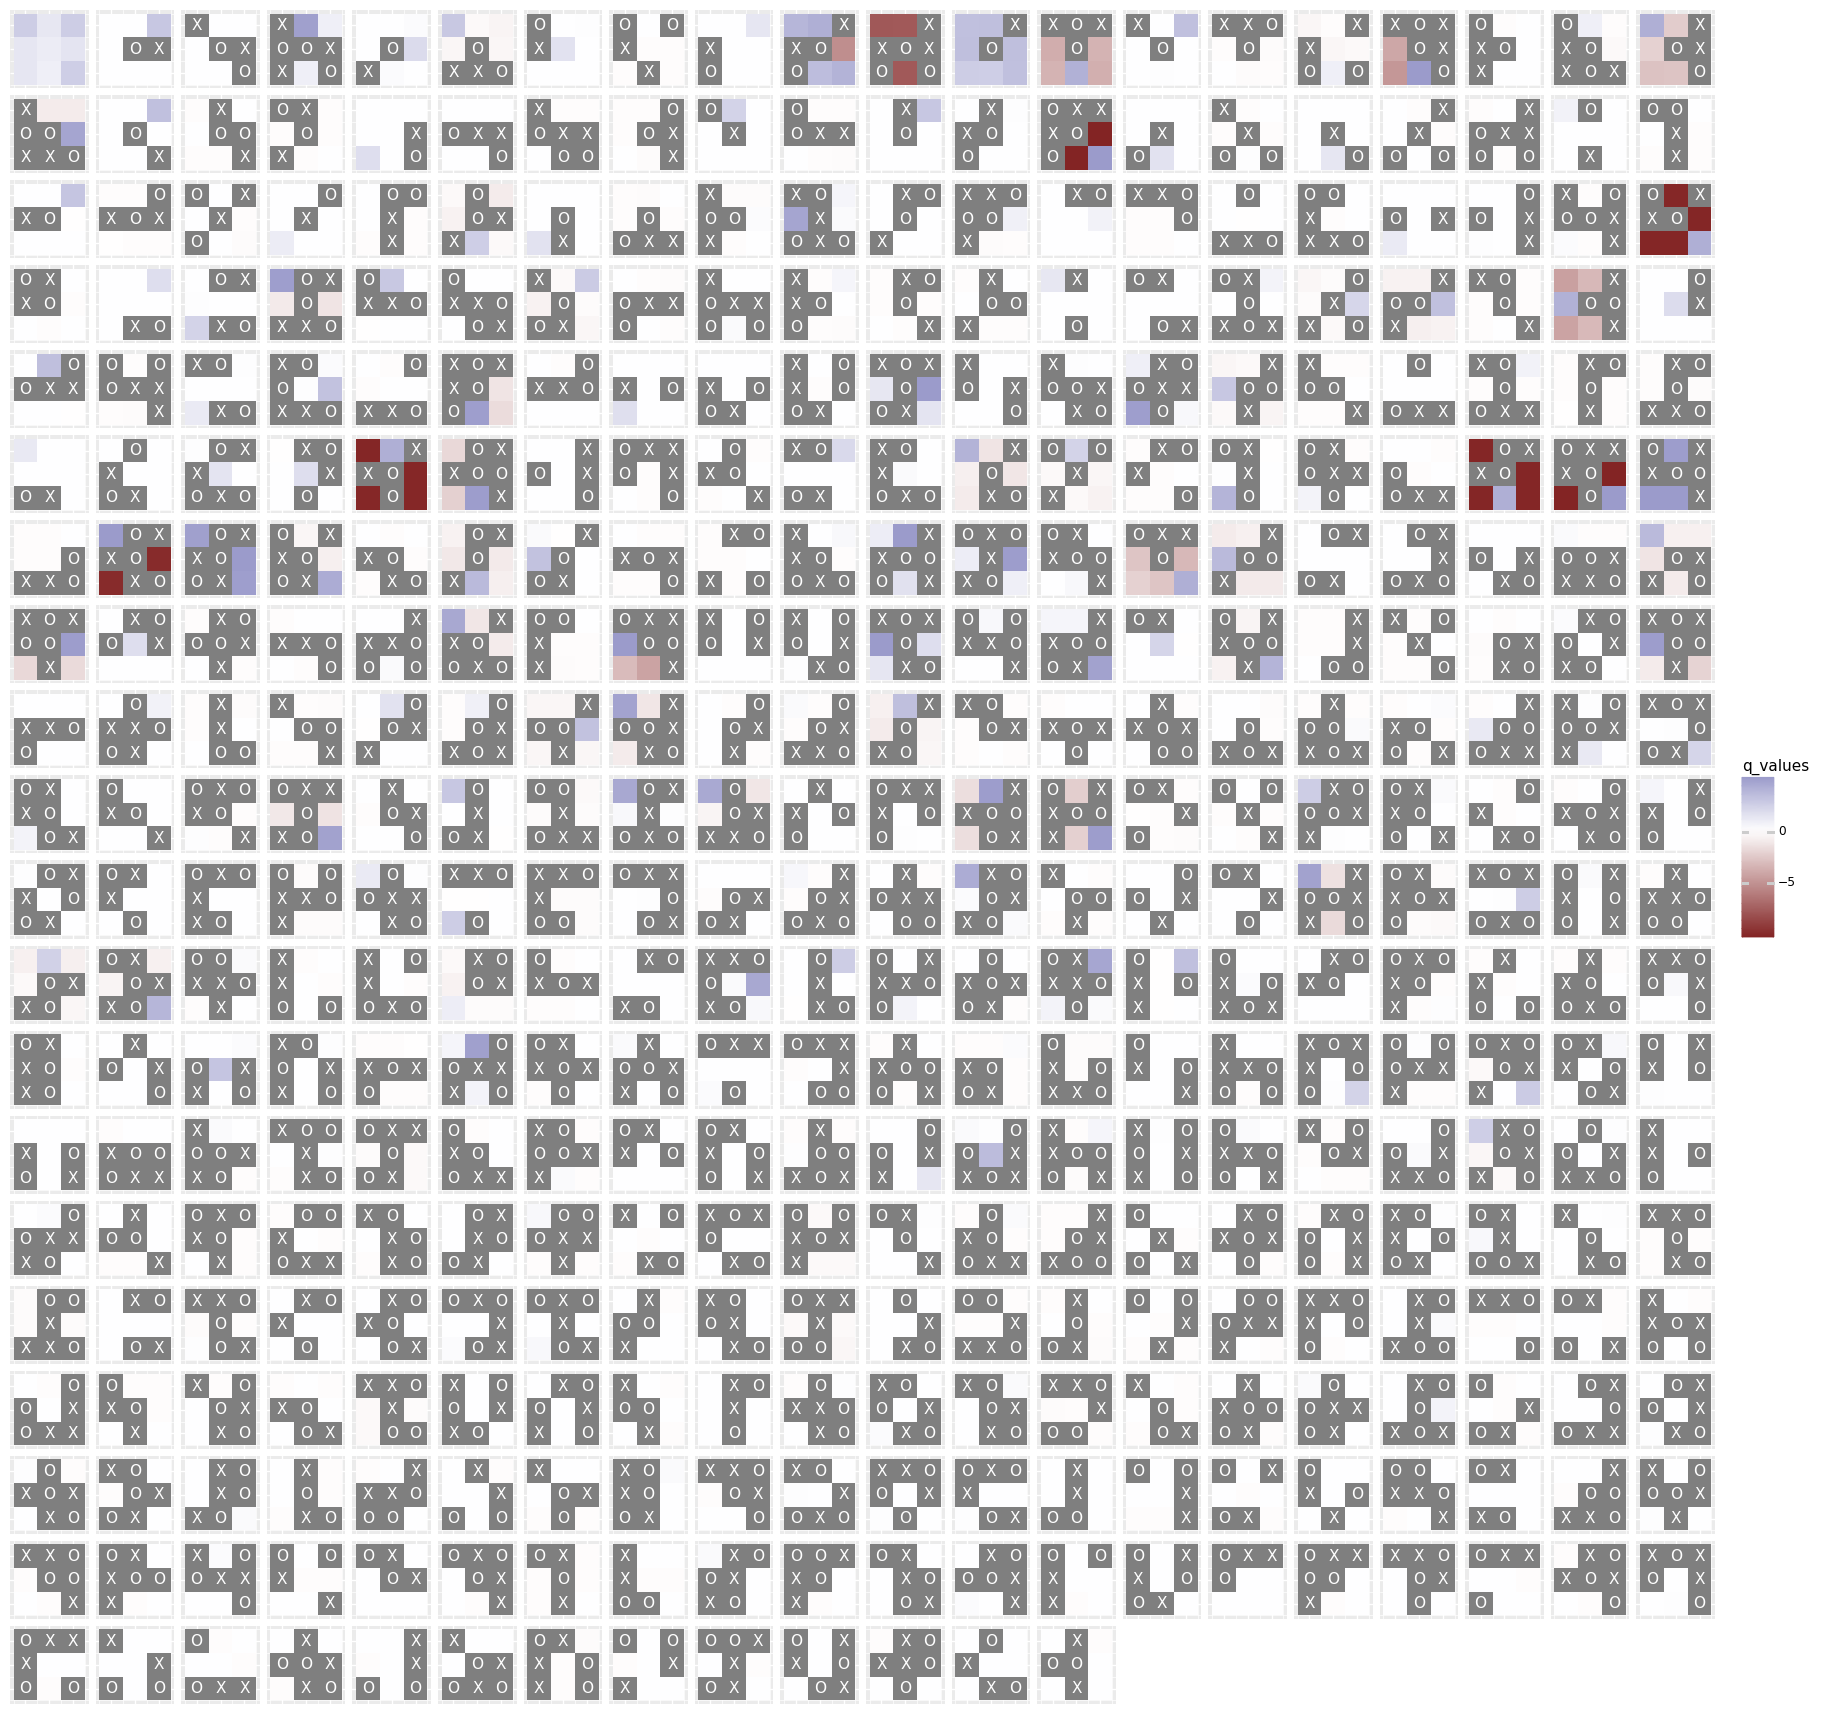

<ggplot: (8766092757995)>

In [10]:
# Wrapped code in a function:
def get_for_sha1(sha1_state):
    def try_na(qt, action):
        # See if an action exists for a given state, return NA if not
        try:
            return qt[action]
        except KeyError:
            return np.nan

    text_lut = {0: np.nan, 1: 'X', -1: 'O'}
    return pd.DataFrame({'x': np.tile([1, 2, 3], 3), 'y': np.repeat([1, 2, 3], 3), 
                  'board_state': [text_lut[val] for val in board_states[sha1_state].flatten()], 
                  'q_values': [try_na(qtable[sha1_state], action) for action in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']], 
                  'sha1_state': sha1_state})

# Use pd.concat and a list comprehension using `get_for_sha1`
plot_data = pd.concat([get_for_sha1(state) for state in states])
# New!:
plot_data['sha1_state'] = pd.Categorical(plot_data['sha1_state'], categories=states)
(
    ggplot(plot_data, aes(x = 'x', y = 'y')) + 
        geom_tile(aes(fill = 'q_values')) + 
        geom_text(aes(label = 'board_state'), color = 'white') + 
        scale_fill_gradient2() + 
        scale_y_reverse() + 
        facet_wrap('~ sha1_state') +  # New!!
        theme(figure_size=(22,22), axis_text=element_blank(), axis_ticks=element_blank(), 
              strip_text_x = element_blank(), axis_title=element_blank())
)

Note that you can find the code in the Player class, more specifically in the `plot_qtable` method. See the [support functions on Github](https://github.com/PaulHiemstra/qtable_movie_paper/blob/master/support_functions.py) for details. 

# Animating the Q table
So far, the visualisation of the Q table was of the final table after 100.000 games played. To get a sense of how the Q table develops over time we can simply plot the Q table throughout the training process and stitch the plots together into a movie. In the script `train_and_generate_frame.py` we train a Q learning agent, but in addition we create plots every so many episodes. The training loop:

In [ ]:
no_episodes = int(sys.argv[1])
frame_counter = 0
plots = {}
for ep_idx in tqdm(range(no_episodes)):
    while not tictactoe.is_endstate():
        tictactoe = player_tree.make_move(tictactoe)
        tictactoe = player_tree.make_computer_move(tictactoe)
        player_tree.update_qtable()
    tictactoe.reset_board()
    
    # Specifically meant for plotting the frames in the YT movie
    if ep_idx < 200 or ep_idx % 400 == 0:
        plots[frame_counter] = player_tree.plot_qtable() + ggtitle('Episode %d' % ep_idx)
        frame_counter += 1

now has an additional section which stores a plot of the Q table in a `plots` dictionary. After we have completed the training we can dump these plots as images:

In [ ]:
from tqdm.contrib.concurrent import process_map  

def f(frame_id):
    ggsave(plots[frame_id], filename='plots/qtable_ep%06d.png' % int(frame_id))
    
frame_list = list(plots.keys())
process_map(f, frame_list, max_workers=5)

Note that to save time we use `process_map` from `tqdm` to create 5 worker processes that each dump plots to images on disk. In this way we end up with a couple of hundred images on disk, which we stitch into a movie using `ffmpeg`. On the command line (WSL in my case) I issue the following call to `ffmpeg`: 

    ffmpeg -r 30 -f image2 -s 1920x1080 -i qtable_ep%06d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p qtable.mp4
    
to end up with a 30 second mp4 file:

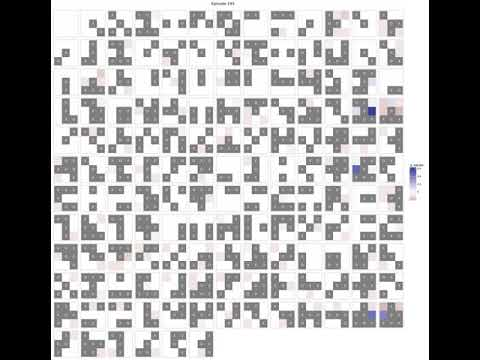

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('9ReBjEf0GAY', width=500, height=500)

As new states are introduced, the table grows. In addition, the white color is slowly replaced by positive (blue) and negative (red) values showing that the agent learns what good and bad moves are. 

# Old code

In [68]:
import dill
from plotnine import *

with open('../RL_p3 - Q-learning/trained_player.pkl', 'rb') as f:
    player = dill.load(f)  
    
board_states = player.board_to_state
states = player.state_list
qtable = player.qtable

with open('rl_data.pkl', 'wb') as f:
    dill.dump([states, board_states, qtable], f)